Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [3]:
n = 2**6
grid = SingleGrid(size=2,n=n)

In [4]:
model_name = 'poisson_mg_kernel_65x65'

training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_65x65.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)

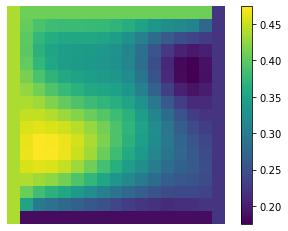

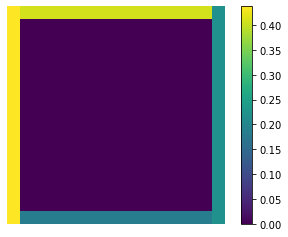

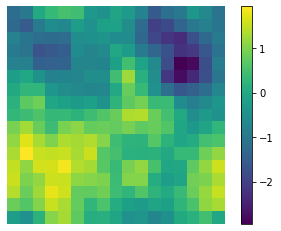

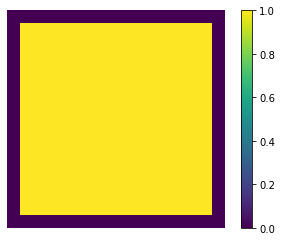

In [5]:
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 1.467322587966919
1 1.057665467262268
2 0.842461347579956
3 0.7083539366722107
4 0.6162753105163574
5 0.5489223599433899
6 0.49737921357154846
7 0.45656031370162964
8 0.42334672808647156
9 0.3957214057445526
10 0.37232521176338196
11 0.35221177339553833
12 0.33470287919044495
13 0.31929928064346313
14 0.3056241571903229
15 0.2933866083621979
16 0.2823571562767029
17 0.27235156297683716
18 0.2632197439670563
19 0.25483787059783936
20 0.247102752327919
21 0.23992794752120972
22 0.23324054479599
23 0.22697873413562775
24 0.2210901528596878
25 0.21553008258342743
26 0.21026046574115753
27 0.20524877309799194
28 0.20046718418598175
29 0.1958918273448944
30 0.1915021538734436
31 0.18728072941303253
32 0.18321220576763153
33 0.17928355932235718
34 0.17548342049121857
35 0.17180196940898895
36 0.16823062300682068
37 0.16476188600063324
38 0.16138921678066254
39 0.15810684859752655
40 0.15490974485874176
41 0.15179325640201569
42 0.14875347912311554
43 0.1457868218421936
44 0.1428898721933365

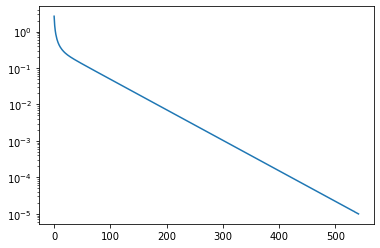

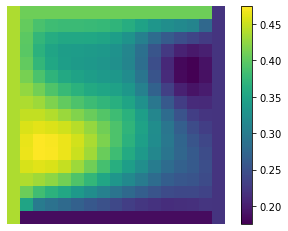

Solution from dataset:


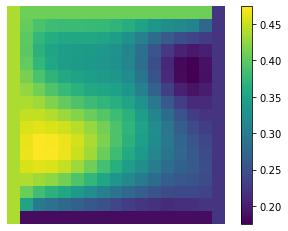

Error (dataset v.s. jacobi):


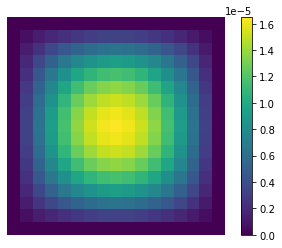

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [7]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0

In [8]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [9]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids

        self.mse_loss = nn.MSELoss()
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        #return self.mse_loss(u, u_star)
        resk = self.f - self.grids[0].Knet(uk)
        res0 = self.f - self.grids[0].Knet(self.u0)
        return torch.mean(torch.pow(torch.norm(resk[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/k))

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.grids[0].ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.grids[0].jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [10]:
def random_sampling(x):
    u = torch.randn_like(x)
    return u

In [11]:
model = MultiGrid(n, linear_tensor_P+0.5*torch.rand((3,3)))
model_linear = MultiGrid(n, linear_tensor_P)

0 2.6261048316955566
1 0.5535693168640137
2 0.1277458518743515
3 0.02979806251823902
4 0.006983594968914986
5 0.0016410991083830595
6 0.00038632890209555626
7 9.10275848582387e-05
8 2.149749889213126e-05
9 5.136856088938657e-06
Solution converges after 9 multi-grid iterations 


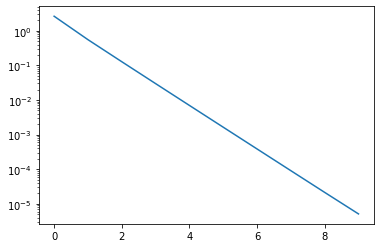

Multigrid solution:


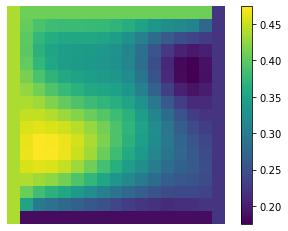

Jacobi solution:


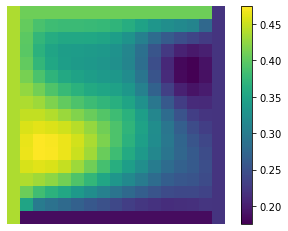

Solution from dataset:


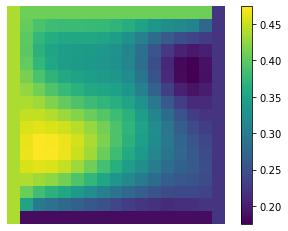

Error (dataset v.s. mg):


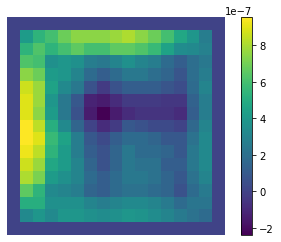

In [12]:
n_multigrid = 0
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model_linear(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
residual = model_linear.f-model_linear.grids[0].Knet(model_linear.u0)
res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model_linear.iterate(u_mg, model_linear.f)
    residual = model_linear.f-model_linear.grids[0].Knet(u_mg)
    res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [13]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.3095, 0.5498, 0.5771],
        [0.7195, 1.4223, 0.5541],
        [0.3519, 0.9880, 0.4926]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.3095, 0.5498, 0.5771],
        [0.7195, 1.4223, 0.5541],
        [0.3519, 0.9880, 0.4926]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [14]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()

In [15]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        u_train, f_train, bc_value_train, bc_index_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        k = random.randint(1,10)
        u0 = random_sampling(f_train)

        u_out = model(u0, f_train, bc_index_train, bc_value_train, k)
        loss_i = model.loss(u_out, k)
        
        loss_i.backward()
        para_list = list(model.parameters())
        optimizer.step()
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [16]:
num_epoch = 1000
best_vloss = 1_000_000.

loss_train = torch.zeros((num_epoch, 1))
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train[epoch] = avg_loss
    kernel_train[epoch] = kernel_i.detach().clone()


0 1.5413937829434872
1 1.7862844127230346
2 1.3339232648722827
3 1.0095472149550915
4 1.049194029532373
5 0.7882129801437259
6 0.7485295576043427
7 0.796218279749155
8 0.5764945317059755
9 0.5609205197542906
10 0.46524614514783025
11 0.36512167006731033
12 0.28775482159107924
13 0.35434835124760866
14 0.30706874281167984
15 0.2171479370445013
16 0.2260702238418162
17 0.1980332308448851
18 0.19781019259244204
19 0.17715605162084103
20 0.17250317241996527
21 0.17746842000633478
22 0.1804916551336646
23 0.17895036842674017
24 0.17676996299996972
25 0.17332723736763
26 0.17565264692530036
27 0.15506438305601478
28 0.1764501528814435
29 0.15653842687606812
30 0.1701374207623303
31 0.16076851822435856
32 0.17546261241659522
33 0.15539168240502477
34 0.17350485594943166
35 0.17241511913016438
36 0.1826102859340608
37 0.16880245646461844
38 0.1659227879717946
39 0.16338473418727517
40 0.16348383389413357
41 0.155791481025517
42 0.1694558928720653
43 0.17376808589324355
44 0.1691450639627874
45

Average q:  tensor(0.1574) , STD:  tensor(0.0088)


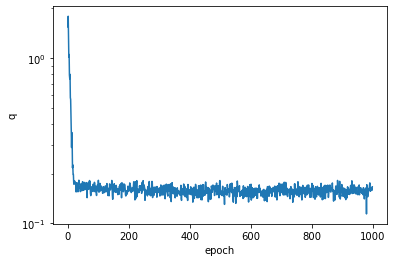

In [17]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

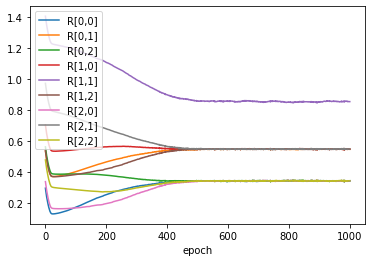

In [18]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,1,0], label="R[1,0]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.plot(kernel_train[:,1,2], label="R[1,2]")
plt.plot(kernel_train[:,2,0], label="R[2,0]")
plt.plot(kernel_train[:,2,1], label="R[2,1]")
plt.plot(kernel_train[:,2,2], label="R[2,2]")
plt.xlabel('epoch')
plt.legend()

In [19]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
torch.save(kernel_train, os.path.join(model_dir,model_name+'-kernels.pt'))

In [20]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
P = torch.mean(Ps[-100:,:,:],dim=0)
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.3414, 0.5475, 0.3416],
        [0.5476, 0.8561, 0.5475],
        [0.3418, 0.5482, 0.3421]])


In [21]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

0 43.98572540283203
1 2.911590576171875
2 0.47166380286216736
3 0.09706799685955048
4 0.02147064544260502
5 0.0048943087458610535
6 0.0011343170190230012
7 0.00026525420253165066
8 6.251188460737467e-05
9 1.4818429008300882e-05
10 3.5687792205862934e-06
Solution converges after 10 multi-grid iterations 


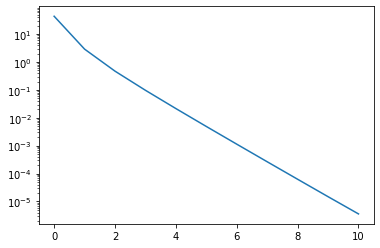

Multigrid solution:


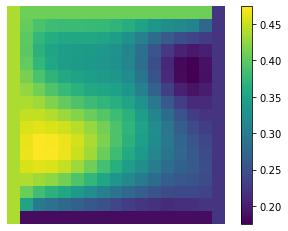

Solution from dataset:


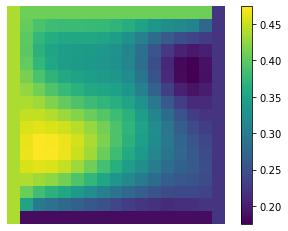

Error (dataset v.s. mg):


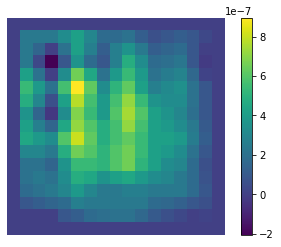

In [22]:
EPS = 1e-5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
u_mg = random_sampling(f_mg)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [23]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.24083384403212785
q hat is: 0.19539830088615417


In [24]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.7486323118209839
2.180116200424433 1.299057960510254
1.314050384415238 2.5074105262756348
1.660086193185547 4.795244216918945
1.4590253859949258 9.18170166015625
1.5574339299470235 17.5819091796875
1.5044118970862383 33.669654846191406
1.5316144889652523 64.47991180419922
1.5172797896840604 123.4853286743164
1.524729644743518 236.48683166503906
1.5208356632350122 452.892822265625
1.5228686080591143 867.3270263671875
1.521807581716616 1661.000244140625
1.5223621543552772 3180.9482421875
1.5220761193389205 6091.72705078125
1.522229061897165 11666.037109375
1.5221443421531504 22341.3046875
1.5221795206773092 42785.7578125
1.5221498285165995 81939.96875
1.5221575094060786 156926.65625
1.522142630510855 300540.90625
1.5221516722458188 575584.8125
1.5221463018145562 1102339.875
1.5221489679090439 2111163.5
1.5221519139071418 4043205.0
1.5221580700113615 7743285.5
1.5221602470205822 14829345.0
1.5221683783588456 28399676.0
1.5221714423300299 54387728.0
1.5221720692501253 104156728.0
1.5

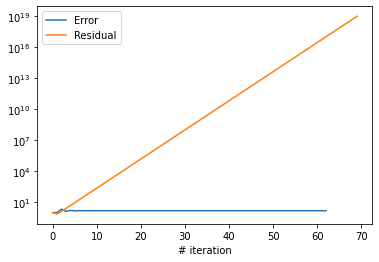

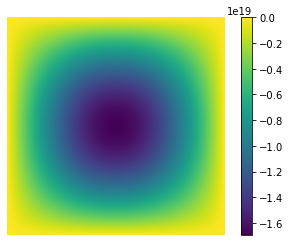

In [25]:
# Multigrid implementation
n = 2**8
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [26]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  inf
